<a href="https://colab.research.google.com/github/OtolaHan/Otola_Han_KAAN/blob/main/LabTimeSeriesLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

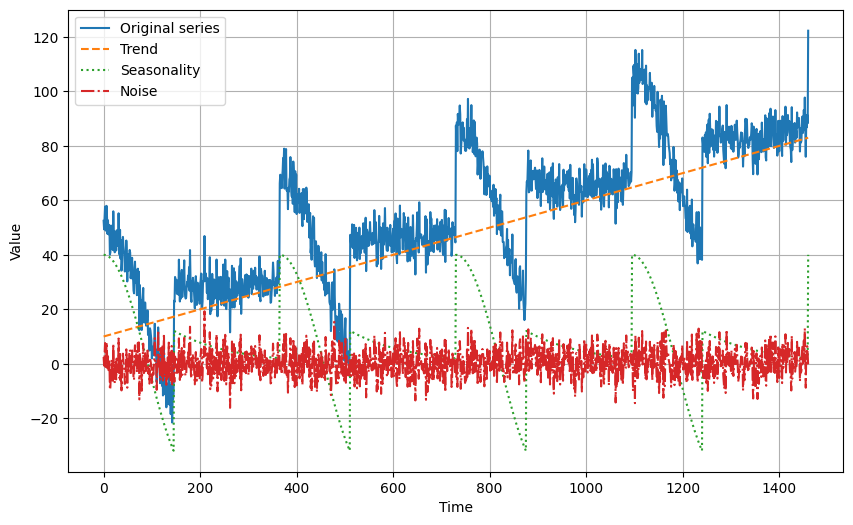

Epoch 1/100
31/31 [==============================] - 0s 3ms/step - loss: 1.4015
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 1.3795
Epoch 3/100
31/31 [==============================] - 0s 4ms/step - loss: 1.3559
Epoch 4/100
31/31 [==============================] - 0s 5ms/step - loss: 1.3329
Epoch 5/100
31/31 [==============================] - 0s 3ms/step - loss: 1.3102
Epoch 6/100
31/31 [==============================] - 0s 4ms/step - loss: 1.2882
Epoch 7/100
31/31 [==============================] - 0s 5ms/step - loss: 1.2666
Epoch 8/100
31/31 [==============================] - 0s 2ms/step - loss: 1.2455
Epoch 9/100
31/31 [==============================] - 0s 2ms/step - loss: 1.2247
Epoch 10/100
31/31 [==============================] - 0s 2ms/step - loss: 1.2045
Epoch 11/100
31/31 [==============================] - 0s 2ms/step - loss: 1.1845
Epoch 12/100
31/31 [==============================] - 0s 2ms/step - loss: 1.1652
Epoch 13/100
31/31 [=================

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Функции для генерации временного ряда и его визуализации
def plot_series(time, series, format="-", start=0, end=None, label=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

# Генерация временного ряда
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5
year = 365

time = np.arange(4 * year + 1, dtype="float32")
series = baseline + trend(time, slope) + seasonality(time, period=year, amplitude=amplitude)
series += noise(time, noise_level, seed=42)

# Визуализация компонентов временного ряда
plt.figure(figsize=(10, 6))
plot_series(time, series, label="Original series")
plot_series(time, baseline + trend(time, slope), label="Trend", format="--")
plot_series(time, seasonality(time, period=year, amplitude=amplitude), label="Seasonality", format=":")
plot_series(time, noise(time, noise_level, seed=42), label="Noise", format="-.")
plt.legend()
plt.show()

# Проверка на NaN значения в данных
assert not np.isnan(series).any(), "Data contains NaN values"

# Нормализация данных
mean = series[:1000].mean()
std = series[:1000].std()
series = (series - mean) / std

# Разделение данных на тренировочные и валидационные наборы
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

# Функция для создания набора данных с окнами
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

# Создание однослойной нейронной сети для линейной регрессии
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1, input_shape=[window_size])
])

# Компиляция модели с исправленным параметром learning_rate
model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6, momentum=0.9))
model.fit(train_set, epochs=100)

# Оценка модели на валидационном наборе
validation_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
mse = model.evaluate(validation_set)
print("Mean Squared Error on validation set:", mse)